In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle, json
import collections

import gensim
from gensim import corpora, similarities
from pprint import pprint
from gensim.utils import simple_preprocess, lemmatize
from gensim.models import CoherenceModel
from gensim.test.utils import datapath

import pyLDAvis
import pyLDAvis.gensim

### Load in models that were run on Google Cloud

In [2]:
model = pickle.load(open("../gcloud/tuned_lda_model.p", "rb"))

In [3]:
model_large_clusters = pickle.load(open("../gcloud/lda_model_final.p", "rb"))

### Load in corpus, dictionary, and text

In [4]:
corpus = pickle.load(open("../gcloud/corpus.p", "rb"))
dictionary = pickle.load(open("../gcloud/dictionary.p", "rb"))

In [5]:
texts = pd.read_csv("../gcloud/recommender_text.csv")

In [6]:
texts.head(50)

,show_names,text_lemmatized
0,'Allo 'Allo!,"['breeze', 'fill', 'tree', 'rare', 'magic', 'p..."
1,'Til Death,"['marry', 'skinny', 'marry', 'scout', 'sell', ..."
2,07 Ghost,"['dream', 'teito', 'wake', 'bell', 'stop', 'ri..."
3,"1,000 Places To See Before You Die","['class', 'credential', 'east', 'allow', 'aust..."
4,10 O'Clock Live,"['clock', 'wednesday', 'february', 'president'..."
5,10 Things I Hate About You,"['cell', 'ring', 'honeys', 'pancake', 'stork',..."
6,100 Days to Victory,"['artillery', 'shell', 'boom', 'plane', 'engin..."
7,100 Greatest Discoveries,"['history', 'light', 'sky', 'sun', 'uncountabl..."
8,100 Questions,"['soul', 'specialist', 'comfortable', 'couch',..."
9,1000 Ways to Die,"['close', 'chef', 'dinner', 'chick', 'hot', 'h..."


In [7]:
#load in coherence score lists from both runs

In [8]:
f = open("../gcloud/num_topics_scores.json", "r")
clusters_scores = json.load(f)
clusters_scores = dict(clusters_scores)
f = open("../gcloud/num_topics_scores_large_clusters.json", "r")
large_clusters_scores = json.load(f)
large_clusters_scores = dict(large_clusters_scores)

In [9]:
all_clusters_scores = {**clusters_scores, **large_clusters_scores}

In [10]:
max(all_clusters_scores.values())

0.2746619049802004

In [11]:
max(all_clusters_scores, key=all_clusters_scores.get)

'10'

### max coherence score occurs when number of clusters=10
### Will choose n=10 LDA as my final model

In [12]:
#plotting coherence score vs number of clusters

In [13]:
clusters = [int(i) for i in all_clusters_scores.keys()]
coherence = [float(j) for j in all_clusters_scores.values()]

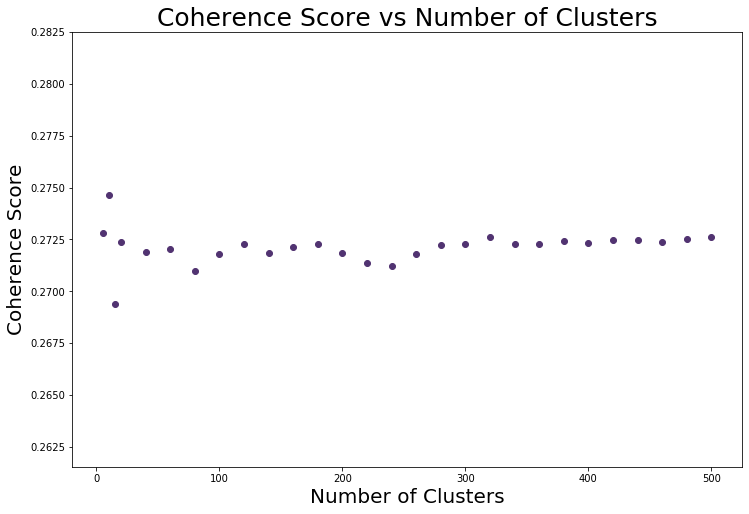

In [14]:
plt.figure(figsize=(12,8))
plt.scatter(clusters, coherence, color="#513371")
plt.title("Coherence Score vs Number of Clusters", fontsize=25)
plt.xlabel("Number of Clusters", fontsize=20)
plt.ylabel("Coherence Score", fontsize=20)
plt.savefig("../github_tv_recommender/television_show_recommender/assets/graphs/coherence_score_number_clusters.png", dpi=300);

In [15]:
model_large_clusters.get_topics()

array([[1.69113002e-04, 2.93478320e-06, 3.60772501e-05, ...,
        1.33311309e-08, 1.33311309e-08, 1.33311309e-08],
       [2.15759865e-04, 8.02805607e-06, 4.49132604e-05, ...,
        1.44957815e-08, 1.44957815e-08, 1.44957815e-08],
       [1.52038207e-04, 9.56789063e-06, 4.66580932e-05, ...,
        1.26119399e-08, 1.26119399e-08, 1.26119399e-08],
       ...,
       [2.09558159e-04, 2.39121050e-06, 4.37311064e-05, ...,
        1.07820615e-08, 1.07820615e-08, 1.07820615e-08],
       [2.07468300e-04, 2.59287481e-06, 4.58954419e-05, ...,
        9.97898120e-09, 9.97898120e-09, 9.97898120e-09],
       [2.09404476e-04, 4.04418824e-06, 4.65022713e-05, ...,
        1.72907129e-08, 1.72907129e-08, 1.72907129e-08]], dtype=float32)

In [16]:
model_large_clusters.get_topics().shape

(10, 636340)

In [17]:
topics = []
for i in range(10):
    tuples = model_large_clusters.get_topic_terms(i)
    topics.append(tuples)


In [18]:
topic_list = []
for i in range(10):
    for j in range(10):
        if topics[i][j][0] in dictionary.keys():
            topic_list.append(dictionary.get(topics[i][j][0]))

In [19]:
len(topic_list)

100

In [20]:
cluster_topics = [topic_list[i:i + 10] for i in range(0, len(topic_list), 10)]

In [21]:
cluster_topics

[['money',
  'school',
  'lie',
  'fire',
  'police',
  'sleep',
  'trust',
  'lose',
  'wear',
  'fall'],
 ['money',
  'doctor',
  'die',
  'sleep',
  'buy',
  'game',
  'fall',
  'light',
  'water',
  'trust'],
 ['money',
  'lie',
  'hate',
  'school',
  'fire',
  'drive',
  'fall',
  'hang',
  'doctor',
  'death'],
 ['school',
  'money',
  'fire',
  'sleep',
  'lie',
  'city',
  'wear',
  'doctor',
  'lose',
  'read'],
 ['money',
  'lie',
  'school',
  'water',
  'turn',
  'miss',
  'fire',
  'hang',
  'drive',
  'blood'],
 ['money',
  'school',
  'doctor',
  'lie',
  'fall',
  'ring',
  'game',
  'light',
  'buy',
  'laugh'],
 ['money',
  'school',
  'work',
  'police',
  'doctor',
  'murder',
  'buy',
  'lie',
  'gun',
  'drive'],
 ['money',
  'lie',
  'school',
  'fire',
  'book',
  'buy',
  'drive',
  'fall',
  'order',
  'catch'],
 ['money',
  'school',
  'fire',
  'lie',
  'die',
  'drive',
  'police',
  'light',
  'buy',
  'death'],
 ['school',
  'money',
  'lie',
  'game',
 

#### Building Similarity Matrix using n=10 model, corpus, and dictionary

In [22]:
dictionary.id2token

{0: 'abandon',
 1: 'aboot',
 2: 'absence',
 3: 'absolute',
 4: 'absolutely',
 5: 'abundantly',
 6: 'abyssinia',
 7: 'access',
 8: 'accidentally',
 9: 'accompany',
 10: 'accomplished',
 11: 'account',
 12: 'ache',
 13: 'acquaint',
 14: 'acquire',
 15: 'acrobatic',
 16: 'acting',
 17: 'action',
 18: 'activate',
 19: 'ad',
 20: 'adc',
 21: 'address',
 22: 'admit',
 23: 'adore',
 24: 'advertise',
 25: 'advice',
 26: 'aerial',
 27: 'aeroplane',
 28: 'afar',
 29: 'affair',
 30: 'affect',
 31: 'afraid',
 32: 'africa',
 33: 'afternoon',
 34: 'aftershave',
 35: 'aftertaste',
 36: 'age',
 37: 'agent',
 38: 'agree',
 39: 'agreeable',
 40: 'ahead',
 41: 'ahem',
 42: 'ahh',
 43: 'ahhh',
 44: 'aim',
 45: 'air',
 46: 'airing',
 47: 'airman',
 48: 'airmen',
 49: 'airworthy',
 50: 'airy',
 51: 'aisle',
 52: 'alarm',
 53: 'alberto',
 54: 'aleck',
 55: 'alfonse',
 56: 'allez',
 57: 'allo',
 58: 'allow',
 59: 'alo',
 60: 'alood',
 61: 'alsatian',
 62: 'altar',
 63: 'alternative',
 64: 'amateurs',
 65: 'am

In [23]:
feature_count = len(dictionary.token2id)

In [24]:
feature_count

636340

In [25]:
vector = model_large_clusters[corpus]

In [26]:
len(vector)

4667

In [27]:
index = similarities.MatrixSimilarity(model_large_clusters[corpus])

In [39]:
index.index[0]

array([0.21219838, 0.1646573 , 0.80631983, 0.08168673, 0.42933849,
       0.13934973, 0.19815949, 0.0948498 , 0.09941993, 0.09559084],
      dtype=float32)

In [28]:
#index = similarities.MatrixSimilarity(model_large_clusters[corpus], num_features = len(dictionary))
# building recommender function
def show_recommender(show_name):
    #format show_name just in case
    #check to make sure TV show is in dataset and get key value from dictionary
    for i in texts["show_names"]:
        if i == show_name:
            print(i)
        #calculate cosine similarity for show
            #show_lda = 
            sims = index[model_large_clusters[i][0]]
            sims = list(enumerate(sims))
            print(len(sims))
            
           # shows_to_compare = []
        #for i in range(len(dictionary)):
         #   other_show = dictionary[i][0]
          #  similarity = round(,3)
            
        

In [40]:
#show_recommender("1600 Penn")